<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-08-27 14:52:01--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-08-27 14:52:01 (87.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



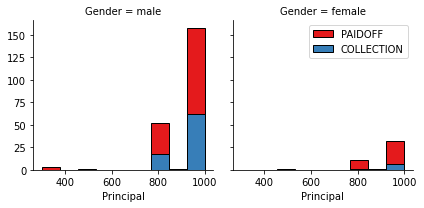

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

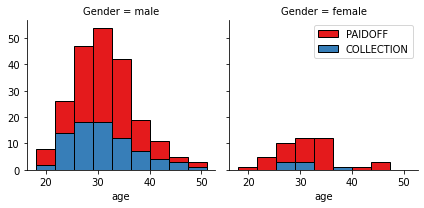

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


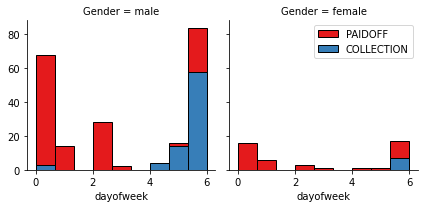

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [22]:
# build KNN with different k and evaluate with accuracy score on "test set"
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# try k from 1 to 10
Ks = 10
mean_acc = np.zeros((Ks))
std_acc = np.zeros((Ks))

for n in range(1, Ks + 1):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    
    mean_acc[n - 1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n - 1] = np.std(yhat==y_test) / np.sqrt(yhat.shape[0])
mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857])

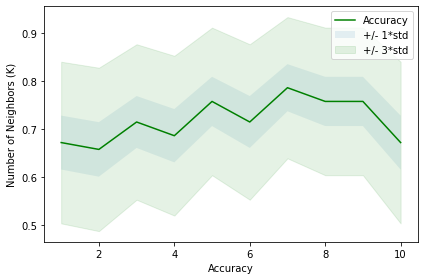

In [23]:
# plot to visualize and find the best k to build the model with the best accuracy
plt.plot(range(1, Ks + 1), mean_acc, 'g')
plt.fill_between(range(1, Ks + 1), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1, Ks + 1), mean_acc - 3 * std_acc, mean_acc + 3 * std_acc, alpha=0.10, color='green')
plt.legend(('Accuracy', '+/- 1*std', '+/- 3*std'))
plt.xlabel('Accuracy')
plt.ylabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [24]:
print('The best accuracy score for K Nearest Neighbor is', mean_acc.max(), 'with k = ', mean_acc.argmax() + 1)

The best accuracy score for K Nearest Neighbor is 0.7857142857142857 with k =  7


In [25]:
# finalize the K Nearest Neighbor using the best k with highest accuracy
knn_mdl = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)

# Decision Tree


In [26]:
# build the decision tree classifier using training set and evaluate with test set
from sklearn.tree import DecisionTreeClassifier
DTree_mdl = DecisionTreeClassifier(criterion='entropy', max_depth=4)
DTree_mdl.fit(X_train, y_train)
predTree = DTree_mdl.predict(X_test)

print(predTree[0:5])
print(y_test[0:5])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [27]:
# Evaluation
print("Decision Tree Classifier's Accuracy:", metrics.accuracy_score(y_test, predTree))

Decision Tree Classifier's Accuracy: 0.6142857142857143


In [30]:
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.8-main

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.5.30          |   py38h578d9bd_0         141 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    pydotplus-2.0.2            |             py_1          22 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-py_1
  python_abi         conda-forge/linux-64::python_abi-3.8-2_cp38

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi         

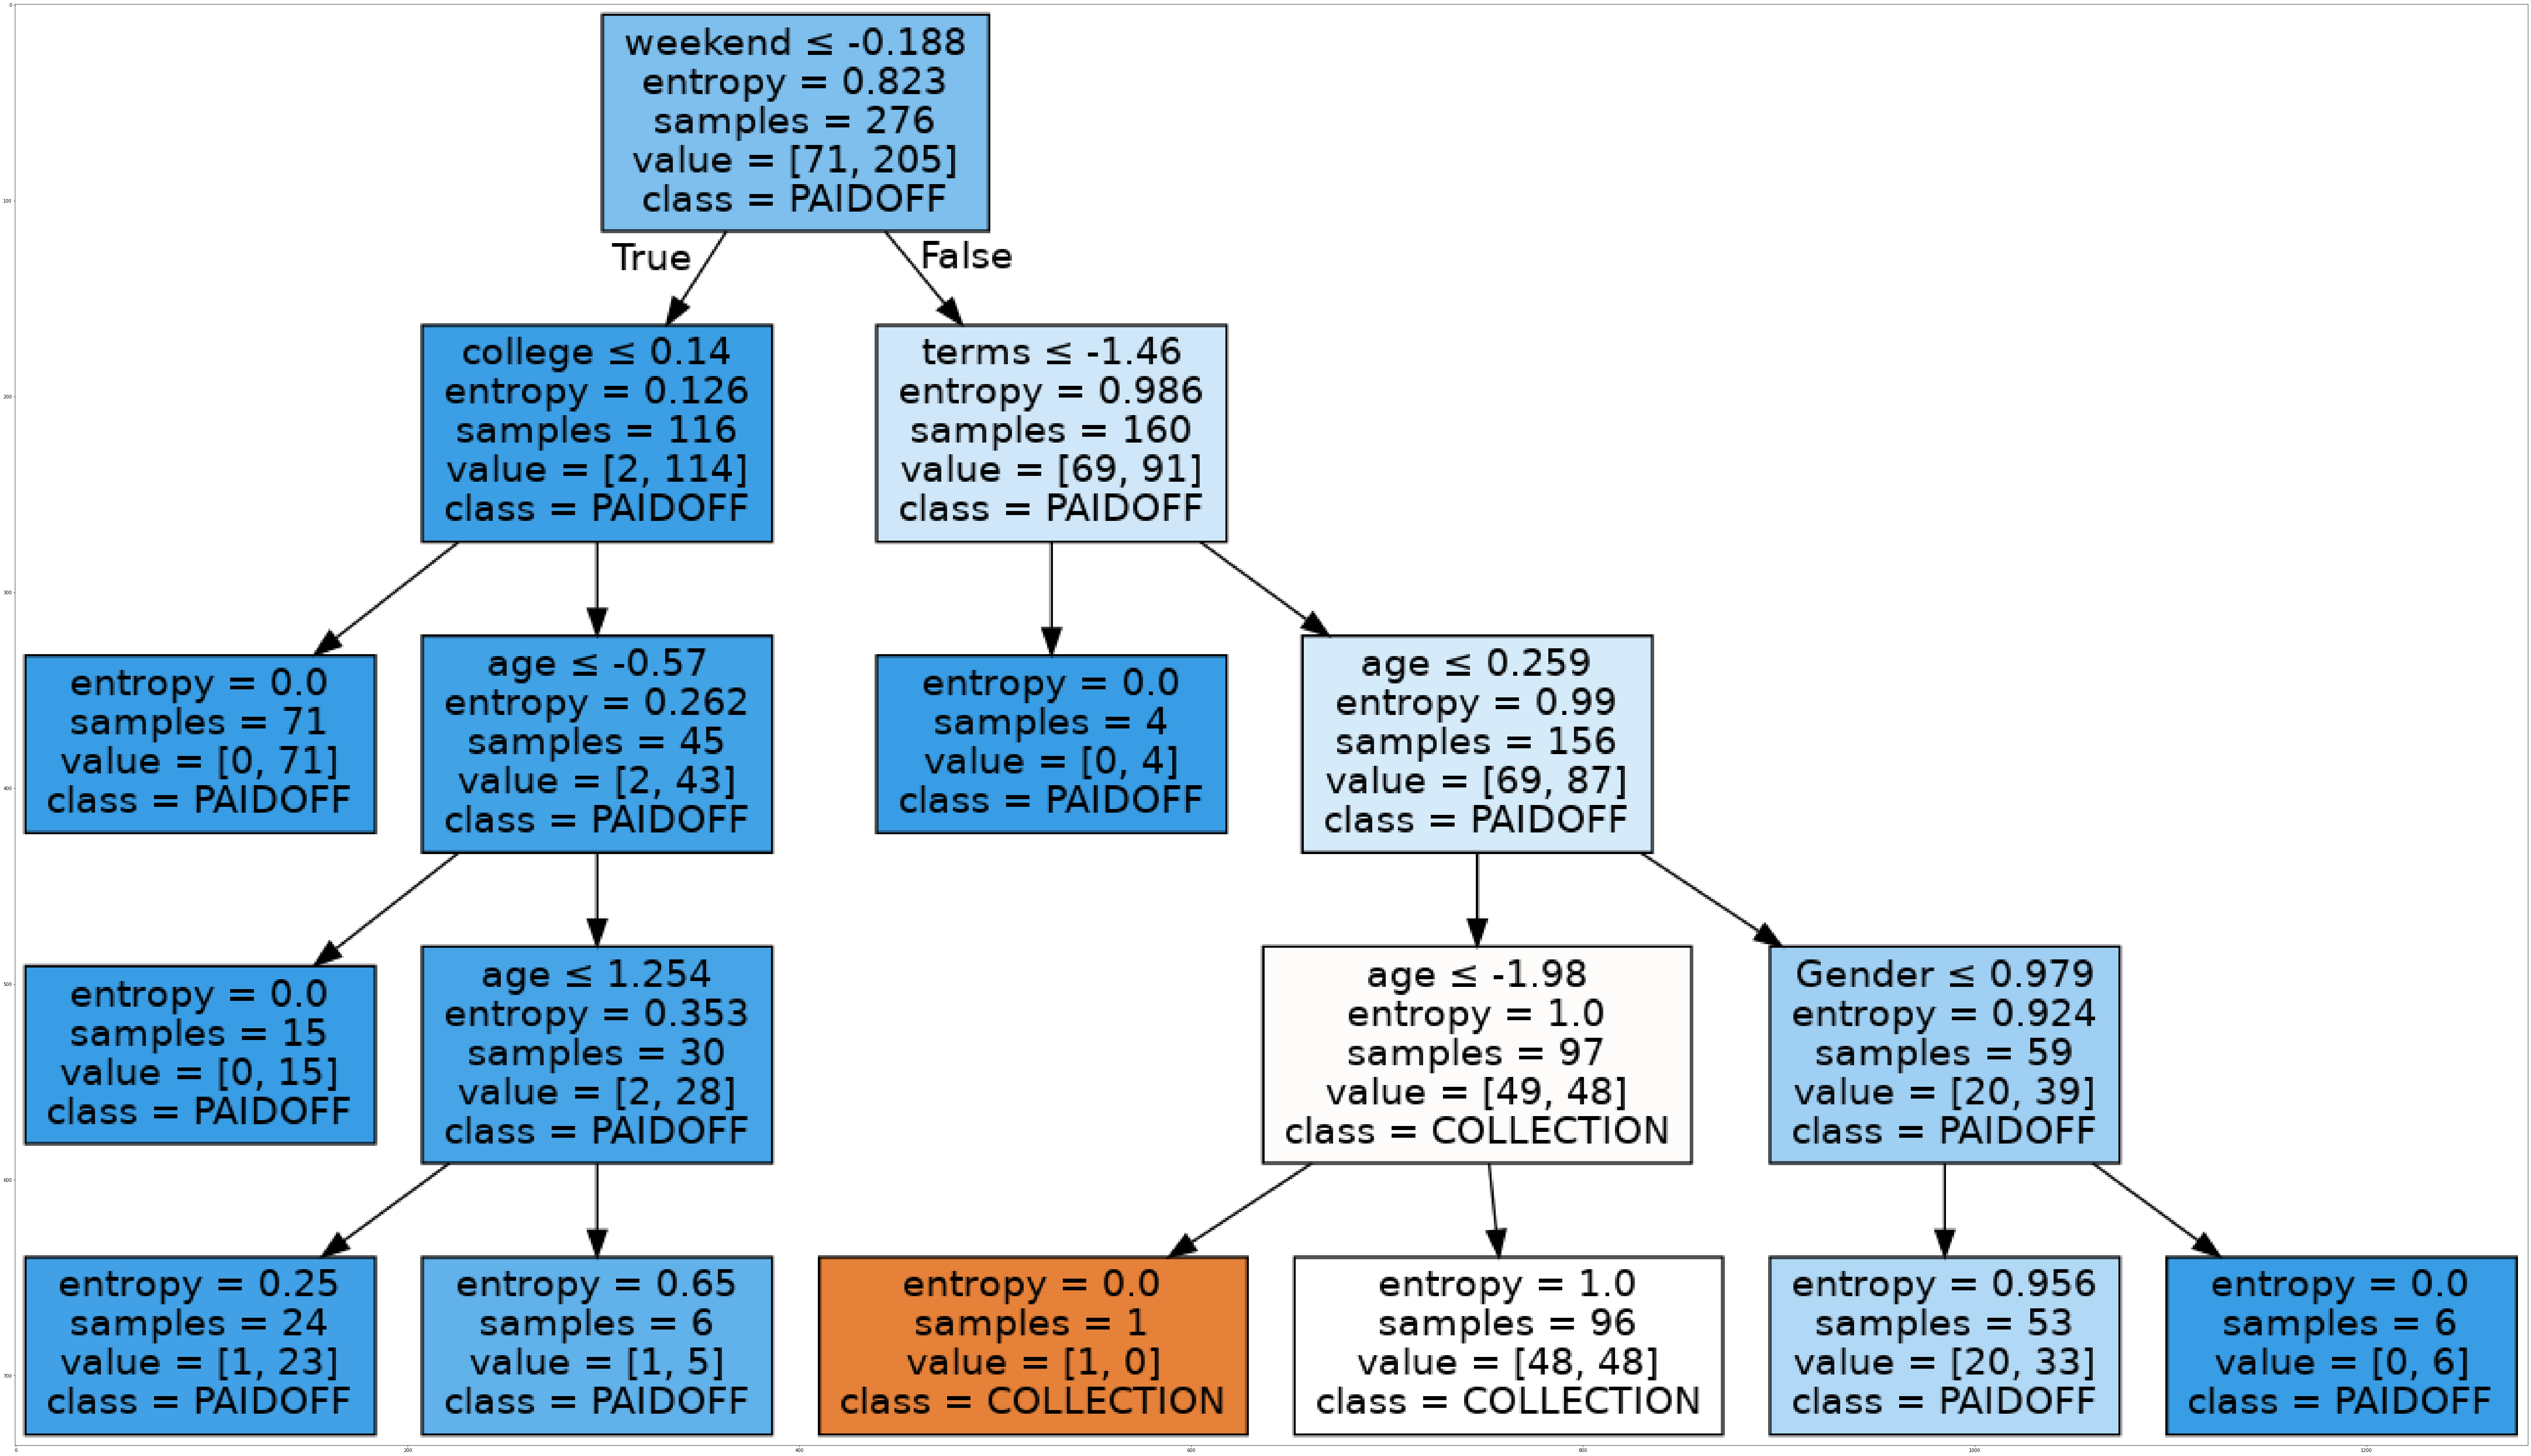

In [31]:
# Visualzation
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

dot_data = StringIO()
filename = 'DecisionTree_LoanClassifier.png'
featureNames = Feature.columns.values
out = tree.export_graphviz(DTree_mdl, feature_names=featureNames, out_file=dot_data, class_names=np.unique(y_train), filled=True, special_characters=True, rotate=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation='nearest')


# Support Vector Machine


In [32]:
# 1. using kernel: Radial basis function (RBF)
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, jaccard_score

clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)
yhat_rbf = clf_rbf.predict(X_test)

# evaluation
cnf_rbf = confusion_matrix(y_test, yhat_rbf, labels=['COLLECTION', 'PAIDOFF'])
clrepr_rbf = classification_report(y_test, yhat_rbf)
f1_rbf = f1_score(y_test, yhat_rbf, average='weighted')
jac_rbf = jaccard_score(y_test, yhat_rbf, pos_label='PAIDOFF')

print('Confusion matrix: \n', cnf_rbf)
print('Classification report: \n', clrepr_rbf)
print("Avg F1-score: %.4f" % f1_rbf)
print("Jaccard score: %.4f" % jac_rbf)

Confusion matrix: 
 [[ 4 11]
 [ 7 48]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Avg F1-score: 0.7276
Jaccard score: 0.7273


In [33]:
# 2. using kernel: Linear

clf_lin = svm.SVC(kernel='linear')
clf_lin.fit(X_train, y_train)
yhat_lin = clf_lin.predict(X_test)

# evaluation
cnf_lin = confusion_matrix(y_test, yhat_lin, labels=['COLLECTION', 'PAIDOFF'])
clrepr_lin = classification_report(y_test, yhat_lin)
f1_lin = f1_score(y_test, yhat_lin, average='weighted')
jac_lin = jaccard_score(y_test, yhat_lin, pos_label='PAIDOFF')

print('Confusion matrix: \n', cnf_lin)
print('Classification report: \n', clrepr_lin)
print("Avg F1-score: %.4f" % f1_lin)
print("Jaccard score: %.4f" % jac_lin)

Confusion matrix: 
 [[ 0 15]
 [ 0 55]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Avg F1-score: 0.6914
Jaccard score: 0.7857


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# 3. using kernel: Polynomial

clf_poly = svm.SVC(kernel='poly')
clf_poly.fit(X_train, y_train)
yhat_poly = clf_poly.predict(X_test)

# evaluation
cnf_poly = confusion_matrix(y_test, yhat_poly, labels=['COLLECTION', 'PAIDOFF'])
clrepr_poly = classification_report(y_test, yhat_poly)
f1_poly = f1_score(y_test, yhat_poly, average='weighted')
jac_poly = jaccard_score(y_test, yhat_poly, pos_label='PAIDOFF')

print('Confusion matrix: \n', cnf_poly)
print('Classification report: \n', clrepr_poly)
print("Avg F1-score: %.4f" % f1_poly)
print("Jaccard score: %.4f" % jac_poly)

Confusion matrix: 
 [[ 1 14]
 [ 2 53]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

    accuracy                           0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Avg F1-score: 0.7065
Jaccard score: 0.7681


In [35]:
# 4. using kernel: Sigmoid

clf_sig = svm.SVC(kernel='sigmoid')
clf_sig.fit(X_train, y_train)
yhat_sig = clf_sig.predict(X_test)

# evaluation
cnf_sig = confusion_matrix(y_test, yhat_sig, labels=['COLLECTION', 'PAIDOFF'])
clrepr_sig = classification_report(y_test, yhat_sig)
f1_sig = f1_score(y_test, yhat_sig, average='weighted')
jac_sig = jaccard_score(y_test, yhat_sig, pos_label='PAIDOFF')

print('Confusion matrix: \n', cnf_sig)
print('Classification report: \n', clrepr_sig)
print("Avg F1-score: %.4f" % f1_sig)
print("Jaccard score: %.4f" % jac_sig)

Confusion matrix: 
 [[ 1 14]
 [ 4 51]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.20      0.07      0.10        15
     PAIDOFF       0.78      0.93      0.85        55

    accuracy                           0.74        70
   macro avg       0.49      0.50      0.48        70
weighted avg       0.66      0.74      0.69        70

Avg F1-score: 0.6893
Jaccard score: 0.7391


In [36]:
# Finally using kernel: Radial basis function (RBF), since it has the highest average F1-score, relatively good precision and recall for both COLLECTION and PAIDOFF classes

# Logistic Regression


In [37]:
# Test with different solvers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# 1. ‘newton-cg’
LR1 = LogisticRegression(C=1, solver='newton-cg')
LR1.fit(X_train, y_train)
yhat1 = LR1.predict(X_test)
yhat_prob1 = LR1.predict_proba(X_test)

# evaluation
cnf_LR1 = confusion_matrix(y_test, yhat1, labels=['COLLECTION', 'PAIDOFF'])
clrepr_LR1 = classification_report(y_test, yhat1)
f1_LR1 = f1_score(y_test, yhat1, average='weighted')
jac_LR1 = jaccard_score(y_test, yhat1, pos_label='PAIDOFF')
logloss_LR1 = log_loss(y_test, yhat_prob1)

print('Confusion matrix: \n', cnf_LR1)
print('Classification report: \n', clrepr_LR1)
print("Avg F1-score: %.4f" % f1_LR1)
print("Jaccard score: %.4f" % jac_LR1)
print ("LogLoss: : %.2f" % logloss_LR1)


Confusion matrix: 
 [[ 2 13]
 [ 6 49]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.25      0.13      0.17        15
     PAIDOFF       0.79      0.89      0.84        55

    accuracy                           0.73        70
   macro avg       0.52      0.51      0.51        70
weighted avg       0.67      0.73      0.70        70

Avg F1-score: 0.6954
Jaccard score: 0.7206
LogLoss: : 0.50


In [38]:
# 2. ‘lbfgs’
LR2 = LogisticRegression(C=1, solver='lbfgs')
LR2.fit(X_train, y_train)
yhat2 = LR2.predict(X_test)
yhat_prob2 = LR2.predict_proba(X_test)

# evaluation
cnf_LR2 = confusion_matrix(y_test, yhat2, labels=['COLLECTION', 'PAIDOFF'])
clrepr_LR2 = classification_report(y_test, yhat2)
f1_LR2 = f1_score(y_test, yhat2, average='weighted')
jac_LR2 = jaccard_score(y_test, yhat2, pos_label='PAIDOFF')
logloss_LR2 = log_loss(y_test, yhat_prob2)

print('Confusion matrix: \n', cnf_LR2)
print('Classification report: \n', clrepr_LR2)
print("Avg F1-score: %.4f" % f1_LR2)
print("Jaccard score: %.4f" % jac_LR2)
print ("LogLoss: : %.2f" % logloss_LR2)


Confusion matrix: 
 [[ 2 13]
 [ 6 49]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.25      0.13      0.17        15
     PAIDOFF       0.79      0.89      0.84        55

    accuracy                           0.73        70
   macro avg       0.52      0.51      0.51        70
weighted avg       0.67      0.73      0.70        70

Avg F1-score: 0.6954
Jaccard score: 0.7206
LogLoss: : 0.50


In [39]:
# 3. ‘liblinear’
LR3 = LogisticRegression(C=1, solver='liblinear')
LR3.fit(X_train, y_train)
yhat3 = LR3.predict(X_test)
yhat_prob3 = LR3.predict_proba(X_test)

# evaluation
cnf_LR3 = confusion_matrix(y_test, yhat3, labels=['COLLECTION', 'PAIDOFF'])
clrepr_LR3 = classification_report(y_test, yhat3)
f1_LR3 = f1_score(y_test, yhat3, average='weighted')
jac_LR3 = jaccard_score(y_test, yhat3, pos_label='PAIDOFF')
logloss_LR3 = log_loss(y_test, yhat_prob3)

print('Confusion matrix: \n', cnf_LR3)
print('Classification report: \n', clrepr_LR3)
print("Avg F1-score: %.4f" % f1_LR3)
print("Jaccard score: %.4f" % jac_LR3)
print ("LogLoss: : %.2f" % logloss_LR3)


Confusion matrix: 
 [[ 2 13]
 [ 7 48]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.22      0.13      0.17        15
     PAIDOFF       0.79      0.87      0.83        55

    accuracy                           0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.67      0.71      0.69        70

Avg F1-score: 0.6860
Jaccard score: 0.7059
LogLoss: : 0.50


In [40]:
# 4. ‘sag’
LR4 = LogisticRegression(C=1, solver='sag')
LR4.fit(X_train, y_train)
yhat4 = LR4.predict(X_test)
yhat_prob4 = LR4.predict_proba(X_test)

# evaluation
cnf_LR4 = confusion_matrix(y_test, yhat4, labels=['COLLECTION', 'PAIDOFF'])
clrepr_LR4 = classification_report(y_test, yhat4)
f1_LR4 = f1_score(y_test, yhat4, average='weighted')
jac_LR4 = jaccard_score(y_test, yhat4, pos_label='PAIDOFF')
logloss_LR4 = log_loss(y_test, yhat_prob4)

print('Confusion matrix: \n', cnf_LR4)
print('Classification report: \n', clrepr_LR4)
print("Avg F1-score: %.4f" % f1_LR4)
print("Jaccard score: %.4f" % jac_LR4)
print ("LogLoss: : %.2f" % logloss_LR4)


Confusion matrix: 
 [[ 2 13]
 [ 6 49]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.25      0.13      0.17        15
     PAIDOFF       0.79      0.89      0.84        55

    accuracy                           0.73        70
   macro avg       0.52      0.51      0.51        70
weighted avg       0.67      0.73      0.70        70

Avg F1-score: 0.6954
Jaccard score: 0.7206
LogLoss: : 0.50


In [41]:
# 5. ‘saga’
LR5 = LogisticRegression(C=1, solver='saga')
LR5.fit(X_train, y_train)
yhat5 = LR5.predict(X_test)
yhat_prob5 = LR5.predict_proba(X_test)

# evaluation
cnf_LR5 = confusion_matrix(y_test, yhat5, labels=['COLLECTION', 'PAIDOFF'])
clrepr_LR5 = classification_report(y_test, yhat5)
f1_LR5 = f1_score(y_test, yhat5, average='weighted')
jac_LR5 = jaccard_score(y_test, yhat5, pos_label='PAIDOFF')
logloss_LR5 = log_loss(y_test, yhat_prob5)

print('Confusion matrix: \n', cnf_LR5)
print('Classification report: \n', clrepr_LR5)
print("Avg F1-score: %.4f" % f1_LR5)
print("Jaccard score: %.4f" % jac_LR5)
print ("LogLoss: : %.2f" % logloss_LR5)

Confusion matrix: 
 [[ 2 13]
 [ 6 49]]
Classification report: 
               precision    recall  f1-score   support

  COLLECTION       0.25      0.13      0.17        15
     PAIDOFF       0.79      0.89      0.84        55

    accuracy                           0.73        70
   macro avg       0.52      0.51      0.51        70
weighted avg       0.67      0.73      0.70        70

Avg F1-score: 0.6954
Jaccard score: 0.7206
LogLoss: : 0.50


In [ ]:
# Roughly similar performance, choose lbfgs solver as a representative

# Model Evaluation using Test set


In [42]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [43]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-08-27 15:27:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-08-27 15:27:11 (43.0 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [44]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [45]:
test_df.shape

(54, 10)

In [46]:
test_df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

### Transform the test set to features

In [47]:
# Convert to date time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [48]:
# Feature selection/extraction
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [49]:
# Convert Categorical features to numerical values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# One Hot Encoding
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature, pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [50]:
# Feature and response for test set
test_X = test_Feature
test_y = test_df['loan_status'].values

# Normalize Data
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)

### Evalaute different models on test set

In [54]:
# 1. KNN
yhat_knn = knn_mdl.predict(test_X)

f1_knn = f1_score(test_y, yhat_knn, average='weighted')
jac_knn = jaccard_score(test_y, yhat_knn, pos_label='PAIDOFF')

print("Avg F1-score for KNN: %.4f" % f1_knn)
print("Jaccard score for KNN: %.4f" % jac_knn)

Avg F1-score for KNN: 0.6328
Jaccard score for KNN: 0.6538 


In [57]:
# 2. Decision Tree
yhat_dtree = DTree_mdl.predict(test_X)

f1_dtree = f1_score(test_y, yhat_dtree, average='weighted')
jac_dtree = jaccard_score(test_y, yhat_dtree, pos_label='PAIDOFF')

print("Avg F1-score for Decision Tree: %.4f" % f1_dtree)
print("Jaccard score for Decision Tree: %.4f" % jac_dtree)

Avg F1-score for Decision Tree: 0.7367
Jaccard score for Decision Tree: 0.6591


In [58]:
# 3. SVM
yhat_svm = clf_rbf.predict(test_X)

f1_svm = f1_score(test_y, yhat_svm, average='weighted')
jac_svm = jaccard_score(test_y, yhat_svm, pos_label='PAIDOFF')

print("Avg F1-score for SVM: %.4f" % f1_svm)
print("Jaccard score for SVM: %.4f" % jac_svm)

Avg F1-score for SVM: 0.7584
Jaccard score for SVM: 0.7800


In [59]:
# 4. Logistic Regression
yhat_LR = LR2.predict(test_X)
yhat_probLR = LR2.predict_proba(test_X)

f1_LR = f1_score(test_y, yhat_LR, average='weighted')
jac_LR = jaccard_score(test_y, yhat_LR, pos_label='PAIDOFF')
logloss_LR = log_loss(test_y, yhat_probLR)

print("Avg F1-score for Logistic Regression: %.4f" % f1_LR)
print("Jaccard score for Logistic Regression: %.4f" % jac_LR)
print ("LogLoss for Logistic Regression: %.2f" % logloss_LR)


Avg F1-score for Logistic Regression: 0.6604
Jaccard score for Logistic Regression: 0.7358
LogLoss for Logistic Regression: 0.47


### Summary Report

In [60]:
report = pd.DataFrame(columns=['Jaccard', 'F1-score', 'LogLoss'])
report.at['KNN', :] = [jac_knn, f1_knn, np.nan]
report.at['Decision Tree', :] = [jac_dtree, f1_dtree, np.nan]
report.at['SVM', :] = [jac_svm, f1_svm, np.nan]
report.at['LogisticRegression', :] = [jac_LR, f1_LR, logloss_LR]
report.index.name = 'Algorithm'

In [61]:
report 
# SVM is the best model amongst the four tested classifiers, in terms of F1-score and Jaccard Score

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.653846,0.63284,NaN
Decision Tree,0.659091,0.736682,NaN
SVM,0.78,0.75835,NaN
LogisticRegression,0.735849,0.660427,0.470915


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
